## IMPORTING

In [7]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

from densepose import add_densepose_config

#According to https://github.com/facebookresearch/DensePose/blob/main/challenge/2019_COCO_DensePose/data_format.md
DP_BODY_PARTS = {
    1: "Torso", 2: "Torso",
    3: "Right Hand", 4: "Left Hand",
    5: "Left Foot", 6: "Right Foot",
    7: "Upper Leg Right", 8: "Upper Leg Left",
    9: "Upper Leg Right", 10: "Upper Leg Left",
    11: "Lower Leg Right", 12: "Lower Leg Left",
    13: "Lower Leg Right", 14: "Lower Leg Left",
    15: "Upper Arm Left", 16: "Upper Arm Right",
    17: "Upper Arm Left", 18: "Upper Arm Right",
    19: "Lower Arm Left", 20: "Lower Arm Right",
    21: "Lower Arm Left", 22: "Lower Arm Right",
    23: "Head", 24: "Head"
}

from libs.STAR.star.pytorch.star import STAR

#According to https://github.com/ahmedosman/STAR/blob/bc6aa8d9be1192ce90d394fdf8898347ec31fe39/demo/load_tf.py
NTHETAS = 72 #number of pose parameters -> 24 joints with 3 rotation values ​​each
NBETAS = 10 #number of shape parameters
NTRANS = 3 #number of translation paramete

#Comparing DP_BODY_PARTS with https://meshcapade.wiki/assets/SMPL_body_segmentation/smpl/smpl_vert_segmentation.json
DP_TO_SMPL = {
    "Torso": ["spine1", "spine2", "spine", "hips"],
    "Right Hand": ["rightHand", "rightHandIndex1"],
    "Left Hand": ["leftHand", "leftHandIndex1"],
    "Left Foot": ["leftFoot", "leftToeBase"],
    "Right Foot": ["rightFoot", "rightToeBase"],
    "Upper Leg Right": ["rightUpLeg"],
    "Upper Leg Left": ["leftUpLeg"],
    "Lower Leg Right": ["rightLeg"],
    "Lower Leg Left": ["leftLeg"],
    "Upper Arm Right": ["rightArm", "rightShoulder"],
    "Upper Arm Left": ["leftArm", "leftShoulder"],
    "Lower Arm Right": ["rightForeArm"],
    "Lower Arm Left": ["leftForeArm"],
    "Head": ["head", "neck"],
}

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import torch
import cv2
import trimesh

import os
import json
import xml
import itertools

## DATA LOADING

In [8]:
SCANPATH = "data/testJorge4x6/"
SCANID = "848312070429"

#Clockwise rotations required 
ROTATIONZ = 0
ROTATIONY = 0 #Useless
ROTATIONX = 0 #Useless

RESULTPATH = os.path.join(os.getcwd(), "results", SCANID)
os.makedirs(RESULTPATH, exist_ok=True)

image = cv2.imread(f"{SCANPATH}{SCANID}-Color-1-calibrated.png")

mesh = trimesh.load_mesh(f"{SCANPATH}{SCANID}-MaskPointCloud-0.ply", file_type="ply", process=False)

cameraf = xml.etree.ElementTree.parse(f"{SCANPATH}cameras.xml")
calib = {}
for sensor in cameraf.getroot().findall(".//sensor"):
    if sensor.attrib.get("id") == SCANID:
        calibration = sensor.find("calibration")
        for param in calibration:
            if param.tag in ("fx", "fy", "cx", "cy"):
                calib[param.tag] = float(param.text)
K = np.array([
    [calib["fx"], 0, calib["cx"]],
    [0, calib["fy"], calib["cy"]],
    [0,           0,           1]
])

if ROTATIONZ != 0:
    h, w = image.shape[:2]
    center = (w/2, h/2)

    M = cv2.getRotationMatrix2D(center=center, angle=-ROTATIONZ, scale=1.0)

    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int(h*sin + w*cos)
    new_h = int(h*cos + w*sin)

    M[0,2] += (new_w-w) / 2
    M[1,2] += (new_h-h) / 2

    image = cv2.warpAffine(image, M, (new_w, new_h))
    M_homogeneous = np.vstack([M, [0, 0, 1]])
    K = M_homogeneous @ K

#From https://github.com/facebookresearch/detectron2/blob/main/projects/DensePose/doc/DENSEPOSE_IUV.md
dp_cfg_iuv = get_cfg()
dp_cfg_iuv.MODEL.DEVICE = "cpu"
add_densepose_config(dp_cfg_iuv)
dp_cfg_iuv.merge_from_file("libs/detectron2/projects/DensePose/configs/densepose_rcnn_R_101_FPN_DL_WC1M_s1x.yaml")
dp_cfg_iuv.MODEL.WEIGHTS = "libs/detectron2/projects/DensePose/models/model_final_0ebeb3.pkl"
dp_predictor_iuv = DefaultPredictor(dp_cfg_iuv)

'''
#From https://github.com/facebookresearch/detectron2/blob/main/projects/DensePose/doc/DENSEPOSE_CSE.md
#From https://github.com/facebookresearch/detectron2/blob/main/projects/DensePose/configs/cse/Base-DensePose-RCNN-FPN-Human.yaml#L12
dp_cfg_cse = get_cfg()
dp_cfg_cse.MODEL.DEVICE = "cpu"
add_densepose_config(dp_cfg_cse)
dp_cfg_cse.merge_from_file("libs/detectron2/projects/DensePose/configs/cse/densepose_rcnn_R_101_FPN_DL_soft_s1x.yaml")
dp_cfg_cse.MODEL.WEIGHTS = "libs/detectron2/projects/DensePose/models/cse/model_final_b236ce.pkl"
dp_cfg_cse.MODEL.ROI_DENSEPOSE_HEAD.CSE.EMBEDDERS.smpl_27554.INIT_FILE = "libs/detectron2/projects/DensePose/models/cse/phi_smpl_27554_256.pkl"
dp_predictor_cse = DefaultPredictor(dp_cfg_cse)
'''

def getAPose(thetas):
    deg2rad = math.pi / 180
    Apose = np.zeros(thetas)
    Apose[48:51] = np.multiply(deg2rad, [0,0,-70]) #Left shoulder
    Apose[51:54] = np.multiply(deg2rad, [0,0,70]) #Right shoulder
    Apose[54:57] = np.multiply(deg2rad, [0,-20,0]) #Left elbow
    Apose[57:60] = np.multiply(deg2rad, [0,20,0]) #Right elbow
    return Apose

with open("data/smpl_vert_segmentation.json", "r") as f:
    smpl_vert_segmentation = json.load(f)

star = STAR(gender="neutral", num_betas=NBETAS)
pose = torch.tensor(getAPose(NTHETAS), dtype=torch.float32).unsqueeze(0)
shape = torch.zeros(1, NBETAS)
trans = torch.zeros(1, NTRANS)
star_model = star(pose, shape, trans)
vstar_model = star_model.detach().numpy()[0]

dict_vids_star = dict(sorted({
    vid: dp_part
    for dp_part in DP_TO_SMPL.keys()
        for smpl_part in DP_TO_SMPL[dp_part]
            for vid in smpl_vert_segmentation[smpl_part]
}.items()))

if ROTATIONY != 0:
    rot_y = scipy.spatial.transform.Rotation.from_rotvec(np.deg2rad(ROTATIONY) * np.array([0, 1, 0]))
    vstar_model = rot_y.apply(vstar_model)
if ROTATIONX != 0:
    rot_x = scipy.spatial.transform.Rotation.from_rotvec(np.deg2rad(ROTATIONX) * np.array([1, 0, 0]))
    vstar_model = rot_x.apply(vstar_model)

CMAP = "tab20"

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


/home/avs/Escritorio/sshare/Proyecto/libs/STAR/models/neutral/model.npz


## IMAGE PREDICTIONS

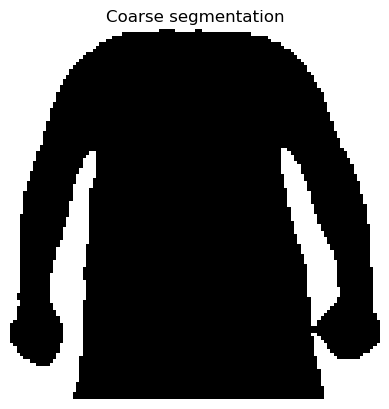

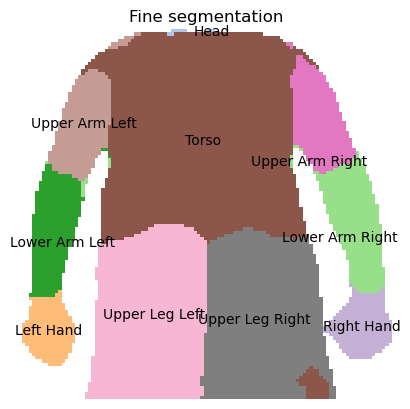

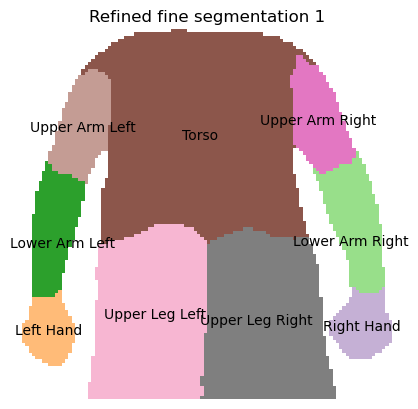

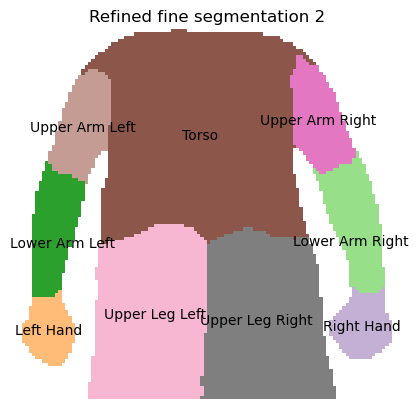

In [9]:
#DensePose predictions
dp_outputs_iuv = dp_predictor_iuv(image)
dp_instances_iuv = dp_outputs_iuv["instances"]
dp_dp_iuv = dp_instances_iuv.pred_densepose[0]
dp_bbox_iuv = dp_instances_iuv.pred_boxes.tensor[0].numpy()
dp_coarse_segm = dp_dp_iuv.coarse_segm.numpy()[0]
dp_fine_segm = dp_dp_iuv.fine_segm.numpy()[0]

'''
dp_outputs_cse = dp_predictor_cse(image)
dp_instances_cse = dp_outputs_cse["instances"]
dp_dp_cse = dp_instances_cse.pred_densepose[0]
dp_bbox_cse = dp_instances_cse.pred_boxes.tensor[0].numpy()
dp_embedding = dp_dp_cse.embedding.numpy()[0]
'''

#Most probable class for each pixel
dp_coarse_mask = dp_coarse_segm.argmax(axis=0)
dp_fine_mask = dp_fine_segm.argmax(axis=0)

#Combination of masks to obtain the body parts within the body area
dp_segm_mask =  dp_fine_mask * dp_coarse_mask

plt.imshow(dp_coarse_mask, cmap="gray_r")
plt.title("Coarse segmentation")
plt.axis("off")
plt.show()

def fixed_coloring_mask(segm_mask):
    '''
    Converts a segmentation mask to a consistent part index mask
    '''

    labels = sorted(set(DP_BODY_PARTS.values()))

    cmap = mpl.colormaps.get_cmap(CMAP)

    fixed_segm_mask = np.vectorize(
        lambda pid: labels.index(DP_BODY_PARTS[pid])+1 if pid in DP_BODY_PARTS else 0
    )(segm_mask)
    colored_mask = cmap(np.ma.masked_where(fixed_segm_mask == 0, fixed_segm_mask))

    return colored_mask

plt.imshow(fixed_coloring_mask(dp_segm_mask))
plt.title("Fine segmentation")

visible_dp_parts = set()
for pid in np.unique(dp_segm_mask):
    #Discard background
    if pid not in DP_BODY_PARTS:
        continue

    #Discard subparts
    part = DP_BODY_PARTS[pid]
    if part in visible_dp_parts:
        continue

    visible_dp_parts.add(part)

    part_mask = (dp_segm_mask == pid)
    y, x = scipy.ndimage.center_of_mass(part_mask)
    plt.text(x, y, part, ha="center", va="center")

plt.axis("off")
plt.show()

'''
plt.imshow(dp_embedding[15,:,:], cmap="viridis")
plt.title("Embedding channel 16")
plt.axis("off")
plt.show()
'''

def smooth_labels(segm_mask, min_component_size=81, structure_size=(3,3)):
    '''
    Reduces noisy parts
    '''

    smooth_segm_mask = np.copy(segm_mask)

    pixels_to_relabel = np.zeros_like(segm_mask, dtype=bool)
    for pid in np.unique(smooth_segm_mask):
        if pid not in DP_BODY_PARTS:
            continue

        part_mask = (smooth_segm_mask == pid)

        #Small components as background
        components_map_mask, num_components = scipy.ndimage.label(
            part_mask
        )
        for i in range(1, num_components+1):
            component_mask = (components_map_mask == i)
            if np.sum(component_mask) < min_component_size:
                pixels_to_relabel[component_mask] = True
                smooth_segm_mask[component_mask] = 0

    #Fills unlabeled pixels
    distances, (nearest_y, nearest_x) = scipy.ndimage.distance_transform_edt(
        smooth_segm_mask == 0,
        return_indices=True
    )
    smooth_segm_mask[pixels_to_relabel] = smooth_segm_mask[nearest_y[pixels_to_relabel], nearest_x[pixels_to_relabel]]

    #Morphological opening (erosion then dilation) to remove small noise and smooth object contours
    structure = np.ones(structure_size, dtype=bool)
    smooth_segm_mask = scipy.ndimage.binary_opening(
        smooth_segm_mask,
        structure=structure
    ).astype(smooth_segm_mask.dtype) * smooth_segm_mask

    return smooth_segm_mask

dp_segm_mask = smooth_labels(dp_segm_mask)

plt.imshow(fixed_coloring_mask(dp_segm_mask))
plt.title("Refined fine segmentation 1")

visible_dp_parts = set()
for pid in np.unique(dp_segm_mask):
    #Discard background
    if pid not in DP_BODY_PARTS:
        continue

    #Discard subparts
    part = DP_BODY_PARTS[pid]
    if part in visible_dp_parts:
        continue

    visible_dp_parts.add(part)

    part_mask = (dp_segm_mask == pid)
    y, x = scipy.ndimage.center_of_mass(part_mask)
    plt.text(x, y, part, ha="center", va="center")

plt.axis("off")
plt.show()

def correct_anatomical_anomalies(segm_mask, min_pixels_for_anomaly=100, proximity_threshold_px=150):
    """
    Corrects anatomical anomalies by facing extremes of body height
    """

    ROLES = {
        "Hand", "Foot", "Upper Arm", "Lower Arm", 
        "Upper Leg", "Lower Leg", "Torso", "Head"
    }
    ROLES_UPPER_BODY = {"Hand", "Lower Arm", "Upper Arm", "Head"}
    ROLES_LOWER_BODY = {"Foot", "Lower Leg", "Upper Leg"}

    ANOMALOUS_PROXIMITY_PAIRS = {
        frozenset({"Hand", "Foot"}),
        frozenset({"Hand", "Lower Leg"}),
        frozenset({"Lower Arm", "Foot"}),
        frozenset({"Lower Arm", "Lower Leg"}),
        frozenset({"Upper Arm", "Foot"}),
        frozenset({"Upper Arm", "Lower Leg"}),
        frozenset({"Upper Arm", "Upper Leg"}),
        frozenset({"Head", "Foot"}),
        frozenset({"Head", "Lower Leg"}),
        frozenset({"Head", "Upper Leg"}),
    }

    correct_segm_mask = np.copy(segm_mask)

    #Extract information from each part
    pids_info = {} 
    for pid in np.unique(correct_segm_mask):
        if pid not in DP_BODY_PARTS:
            continue

        part_mask = (correct_segm_mask == pid)

        part_size = np.sum(part_mask)
        if part_size < min_pixels_for_anomaly:
            continue

        part_name = DP_BODY_PARTS[pid]

        for role_keyword in ROLES:
            if role_keyword in part_name:
                part_role = role_keyword
                break

        y, x = scipy.ndimage.center_of_mass(part_mask)

        pids_info[pid] = {
            "size": part_size,
            "name": part_name,
            "role": part_role,
            "com_y": y,
            "com_x": x
        }

    #Check for anomalous parts
    all_person_y_coords = [part_info["com_y"] for part_info in pids_info.values()]
    estimated_body_min_y = np.min(all_person_y_coords)
    estimated_body_max_y = np.max(all_person_y_coords)
    estimated_body_height = estimated_body_max_y - estimated_body_min_y

    def is_anomalously_positioned(part_info, other_part_info, estimated_min_y, estimated_max_y, estimated_height):
        '''
        Checks if a part is anomalous based on its role and height
        '''
        threshold_y = estimated_min_y + estimated_height * 0.5 

        #It is below the mean threshould Y and is higher than the other part
        if part_info["role"] in ROLES_UPPER_BODY:
            return part_info["com_y"] > threshold_y and part_info["com_y"] >= other_part_info["com_y"]
        #It is above the mean threshould Y and is lower than the other part
        elif part_info["role"] in ROLES_LOWER_BODY:
            return part_info["com_y"] < threshold_y and part_info["com_y"] <= other_part_info["com_y"]
        return False

    #Remove anomalous parts
    removed_pids = set()
    for pid_a, info_a in list(pids_info.items()):
        if pid_a in removed_pids:
            continue

        for pid_b, info_b in list(pids_info.items()):
            if pid_a in removed_pids:
                break

            if pid_b in removed_pids:
                continue

            if pid_a == pid_b:
                continue

            if frozenset({info_a["role"], info_b["role"]}) not in ANOMALOUS_PROXIMITY_PAIRS:
                continue

            distance = np.sqrt((info_a["com_y"] - info_b["com_y"])**2 + (info_a["com_x"] - info_b["com_x"])**2)
            if distance >= proximity_threshold_px:
                continue

            is_a_anomalous = is_anomalously_positioned(info_a, info_b, estimated_body_min_y, estimated_body_max_y, estimated_body_height)
            is_b_anomalous = is_anomalously_positioned(info_b, info_a, estimated_body_min_y, estimated_body_max_y, estimated_body_height)

            if is_a_anomalous and is_b_anomalous:
                #The smaller one in size
                if info_a["size"] < info_b["size"]:
                    pid_to_remove = pid_a
                else:
                    pid_to_remove = pid_b
            elif is_a_anomalous:
                pid_to_remove = pid_a
            elif is_b_anomalous:
                pid_to_remove = pid_b
            else: continue

            #Fill deleted part
            removed_part_info = pids_info[pid_to_remove]

            best_fill_pid = 0 
            min_fill_distance = float("inf")
            for current_pid, current_info in pids_info.items():
                if current_pid == pid_to_remove or current_pid in removed_pids:
                    continue 

                fill_distance = np.sqrt((removed_part_info["com_y"] - current_info["com_y"])**2 + (removed_part_info["com_x"] - current_info["com_x"])**2)

                is_compatible_role = False
                if removed_part_info["role"] in ROLES_UPPER_BODY and current_info["role"] in ROLES_UPPER_BODY:
                    is_compatible_role = True
                elif removed_part_info["role"] in ROLES_LOWER_BODY and current_info["role"] in ROLES_LOWER_BODY:
                    is_compatible_role = True

                if (is_compatible_role and fill_distance < min_fill_distance) or (best_fill_pid == 0 and fill_distance < proximity_threshold_px/2):
                    min_fill_distance = fill_distance
                    best_fill_pid = current_pid

            correct_segm_mask[correct_segm_mask == pid_to_remove] = best_fill_pid

            removed_pids.add(pid_to_remove)

    return correct_segm_mask

dp_segm_mask = correct_anatomical_anomalies(dp_segm_mask)

plt.imshow(fixed_coloring_mask(dp_segm_mask))
plt.title("Refined fine segmentation 2")

visible_dp_parts = set()
for pid in np.unique(dp_segm_mask):
    #Discard background
    if pid not in DP_BODY_PARTS:
        continue

    #Discard subparts
    part = DP_BODY_PARTS[pid]
    if part in visible_dp_parts:
        continue

    visible_dp_parts.add(part)

    part_mask = (dp_segm_mask == pid)
    y, x = scipy.ndimage.center_of_mass(part_mask)
    plt.text(x, y, part, ha="center", va="center")

plt.axis("off")
plt.savefig(RESULTPATH+"/mask_segm.png")
plt.show()

## PART SEGMENTATION

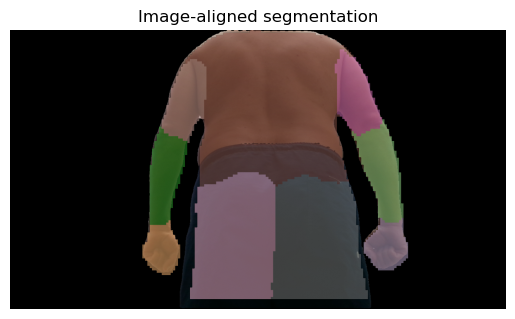

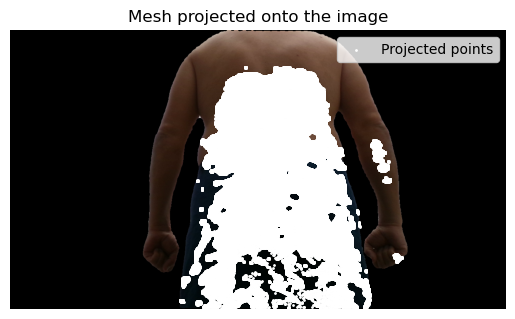

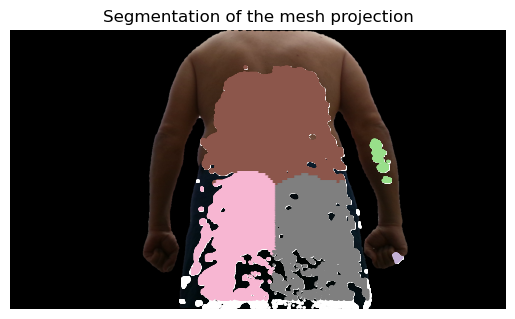

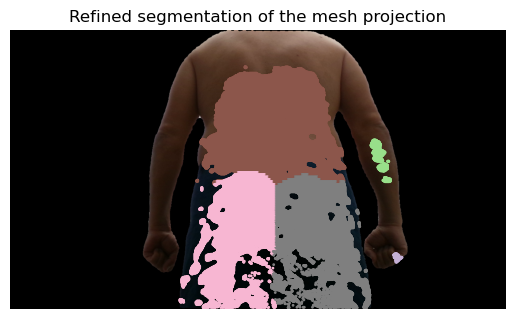

In [10]:
#Align segmentation
x1, y1, x2, y2 = dp_bbox_iuv.astype(int)
h_box, w_box = y2 - y1, x2 - x1
dp_segm_mask_resized = cv2.resize(dp_segm_mask, (w_box, h_box), interpolation=cv2.INTER_NEAREST)
dp_segm_mask_full = np.zeros(image.shape[:2])
dp_segm_mask_full[y1:y2, x1:x2] = dp_segm_mask_resized

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(fixed_coloring_mask(dp_segm_mask_full), alpha=0.5)
plt.title("Image-aligned segmentation")
plt.axis("off")
plt.savefig(RESULTPATH+"/img_segm.png")
plt.show()

def project_points(K, points_3d):
    '''
    Porjects 3D points to 2D using the intrinsic matrix K
    '''

    points_proj_homogeneous = points_3d @ K.T
    points_2d = points_proj_homogeneous[:,:2] / points_proj_homogeneous[:,2:3]
    return np.round(points_2d).astype(int)

mesh_projected_points = project_points(K, mesh.vertices)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(mesh_projected_points[:,0], mesh_projected_points[:,1], label="Projected points", c="white", s=1)
plt.title("Mesh projected onto the image")
plt.axis("off")
plt.legend()
plt.show()

def fixed_coloring_parts(dict_vids):
    '''
    Converts a vertex-to-part mapping to consistent colors per part
    '''
    labels = sorted(set(DP_BODY_PARTS.values()))

    cmap = mpl.colormaps.get_cmap(CMAP)

    fixed_pids = [
        labels.index(dict_vids[vid])+1
            for vid in dict_vids.keys()
    ]
    vertices_color = cmap(fixed_pids)

    return vertices_color

#Mesh dict
h, w = dp_segm_mask_full.shape[:2]
dict_segm_vids_mesh = {
    vid: DP_BODY_PARTS[dp_segm_mask_full[v, u]]
    for vid, (u, v) in enumerate(mesh_projected_points)
        if 0 <= v < h and 0 <= u < w
        and dp_segm_mask_full[v, u] in DP_BODY_PARTS
}
vids_mesh = torch.tensor(list(dict_segm_vids_mesh.keys()))
vmesh = mesh.vertices[vids_mesh]

segm_mesh_projected_points = mesh_projected_points[vids_mesh]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(mesh_projected_points[:,0], mesh_projected_points[:,1], c="white", s=1)
plt.scatter(segm_mesh_projected_points[:,0], segm_mesh_projected_points[:,1], c=fixed_coloring_parts(dict_segm_vids_mesh), s=1)
plt.title("Segmentation of the mesh projection")
plt.axis("off")
plt.show()

def fill_unlabeled_points(dict_segm_vids, vmesh):
    '''
    Fills unlabeled points using the nearest classified neighbor
    '''

    N = vmesh.shape[0]
    all_vids = np.arange(N)

    dict_refined_segm_vids = dict(dict_segm_vids)

    labeled_vids = np.array(list(dict_segm_vids.keys()))
    unlabeled_vids = np.setdiff1d(all_vids, labeled_vids)

    labeled_points = vmesh[labeled_vids]
    tree = scipy.spatial.cKDTree(labeled_points)
    distances, nearest = tree.query(vmesh[unlabeled_vids], k=1)
    for i, vid in enumerate(unlabeled_vids):
        neighbor_vid = labeled_vids[nearest[i]]
        dict_refined_segm_vids[vid] = dict_segm_vids[neighbor_vid]

    return dict_refined_segm_vids

dict_segm_vids_mesh = fill_unlabeled_points(dict_segm_vids_mesh, mesh.vertices)
vids_mesh = torch.tensor(list(dict_segm_vids_mesh.keys()))
vmesh = mesh.vertices[vids_mesh]

mesh_projected_points = mesh_projected_points[vids_mesh]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(mesh_projected_points[:,0], mesh_projected_points[:,1], c=fixed_coloring_parts(dict_segm_vids_mesh), s=1)
plt.title("Refined segmentation of the mesh projection")
plt.axis("off")
plt.savefig(RESULTPATH+"/mesh_proy_segm.png")
plt.show()

trimesh.Trimesh(vertices=vmesh, vertex_colors=fixed_coloring_parts(dict_segm_vids_mesh), process=False
).export(RESULTPATH+"/mesh_refined_segm.ply", file_type="ply")

#Discard parts not found in the mesh
visible_dp_parts = [part
    for part in visible_dp_parts
        if part in dict_segm_vids_mesh.values()
]

#Star dict
dict_segm_vids_star = dict(sorted({
    vid: dp_part
    for dp_part in sorted(visible_dp_parts)
        for smpl_part in DP_TO_SMPL[dp_part]
            for vid in smpl_vert_segmentation[smpl_part]
}.items()))
vids_star = torch.tensor(list(dict_segm_vids_star.keys()))
vstar = vstar_model[vids_star]

trimesh.Trimesh(vstar, vertex_colors=fixed_coloring_parts(dict_segm_vids_star), process=False
).export(RESULTPATH+"/star_segm.ply", file_type="ply");

f_vids = lambda dict_segm_vids: torch.tensor(list(dict_segm_vids.keys()))
f_vids_part = lambda dict_segm_vids, part: [vid
    for vid, p in dict_segm_vids.items()
        if p == part
]

## STAR ALIGNMENT

In [11]:
def align_rigid_transform(src_points, tgt_points):
    '''
    Best-fit transform that maps src_points to tgt_points
    using the Kabsch algorithm (rigid alignment via SVD)
    '''

    centroid_src = src_points.mean(axis=0)
    centroid_tgt = tgt_points.mean(axis=0)

    #Center the points
    src_centered = src_points - centroid_src
    tgt_centered = tgt_points - centroid_tgt

    #Covariance matrix
    H = src_centered.T @ tgt_centered

    #SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    #Avoid reflection
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_tgt - R @ centroid_src

    return R, t

def ransac_kabsch(src_points, tgt_points, threshold=0.02, min_inliers=3):
    '''
    Exhaustive RANSAC with the Kabsch algorithm
    obtaining the inliers, points in pairs that agree with the estimated rigid transformation
    '''

    assert src_points.shape == tgt_points.shape
    N = src_points.shape[0]
    best_inliers = []

    #Choose combination with more inliers that exceed the threshold
    for k in range(min_inliers, N+1):
        for idx in itertools.combinations(range(N), k):
            idx = list(idx)
            src_sample = src_points[idx]
            tgt_sample = tgt_points[idx]

            R_est, t_est = align_rigid_transform(src_sample, tgt_sample)
            src_aligned = (R_est @ src_points.T).T + t_est

            distances = np.linalg.norm(src_aligned - tgt_points, axis=1)
            inliers = [i for i, d in enumerate(distances) if d < threshold]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers

    if len(best_inliers) >= min_inliers:
        print(f"!!! RANSAC success !!! with {len(best_inliers)} inliners of {N}")
        return align_rigid_transform(src_points[best_inliers], tgt_points[best_inliers])
    else:
        print(f"!!! RANSAC failed !!! with {len(best_inliers)} inliners of {N}")
        return align_rigid_transform(src_points, tgt_points)

#Get centroids of each part
centroids_parts_star = []
centroids_parts_mesh = []
for part in visible_dp_parts:
    vids_mesh_part = f_vids_part(dict_segm_vids_mesh, part)
    vids_star_part = f_vids_part(dict_segm_vids_star, part)

    centroid_part_star = vstar_model[vids_star_part,:].mean(axis=0)
    centroid_part_mesh = mesh.vertices[vids_mesh_part].mean(axis=0)

    centroids_parts_star.append(centroid_part_star)
    centroids_parts_mesh.append(centroid_part_mesh)

R, t = ransac_kabsch(np.array(centroids_parts_star), np.array(centroids_parts_mesh))
f_align_vstar = lambda vstar, R=R, t=t: (R @ vstar.T).T + t
f_align_star_model = lambda star_model: f_align_vstar(star_model.detach().numpy()[0])

'''aligned_vstar = f_align_star_model(star_model)[f_vids(dict_segm_vids_star)'''
aligned_vstar = (R @ vstar_model[f_vids(dict_segm_vids_star)].T).T + t

def extract_submesh_faces(faces_full, vids):
    idx_map = {v: i for i, v in enumerate(np.array(vids))}
    return np.array([
        [idx_map[v] for v in face]
            for face in faces_full
                if all(v in idx_map for v in face)
    ])

trimesh.Trimesh(vertices=aligned_vstar, vertex_colors=fixed_coloring_parts(dict_segm_vids_star), process=False
).export(RESULTPATH+"/star_aligned_segm.ply", file_type="ply");
trimesh.Trimesh(vertices=aligned_vstar, vertex_colors=fixed_coloring_parts(dict_segm_vids_star), faces=extract_submesh_faces(star_model.f, f_vids(dict_segm_vids_star)), process=False
).export(RESULTPATH+"/star_aligned_segm_wfaces.ply", file_type="ply");

!!! RANSAC success !!! with 3 inliners of 5


## STAR ADJUSTMENT

In [12]:
trimesh.Trimesh(vertices=vstar_model, process=False
).export(os.getcwd()+"/results"+"/star.ply", file_type="ply");
trimesh.Trimesh(vertices=vstar_model, faces=star_model.f, process=False
).export(os.getcwd()+"/results"+"/star_wfaces.ply", file_type="ply");
trimesh.Trimesh(vertices=vstar_model, vertex_colors=fixed_coloring_parts(dict_vids_star), process=False
).export(os.getcwd()+"/results"+"/star_colored.ply", file_type="ply");
trimesh.Trimesh(vertices=vstar_model, vertex_colors=fixed_coloring_parts(dict_vids_star), faces=star_model.f, process=False
).export(os.getcwd()+"/results"+"/star_colored_wfaces.ply", file_type="ply");

def chamfer_dist(x, y):
    kdtree_y = scipy.spatial.cKDTree(y)
    dist_x_to_y, _ = kdtree_y.query(x, k=1)
    kdtree_x = scipy.spatial.cKDTree(x)
    dist_y_to_x, _ = kdtree_x.query(y, k=1)
    '''return np.mean(dist_x_to_y**2) + np.mean(dist_y_to_x**2)'''
    return np.mean(dist_x_to_y) + np.mean(dist_y_to_x)

def objective_func(params, dict_segm_vids_mesh, dict_segm_vids_star, pose, shape, trans):
    vmesh = mesh.vertices[f_vids(dict_segm_vids_mesh)]

    i_params = 0
    if pose == None:
        pose = torch.tensor(params[:NTHETAS].reshape(1,-1), dtype=torch.float32)
        i_params += NTHETAS
    if shape == None:
        shape = torch.tensor(params[i_params:i_params+NBETAS].reshape(1,-1), dtype=torch.float32)
        i_params += NBETAS
    if trans == None:
        trans = torch.tensor(params[i_params:].reshape(1,-1), dtype=torch.float32)
        i_params += NTRANS

    star_model = star(pose, shape, trans)
    vstar = f_align_star_model(star_model)[f_vids(dict_segm_vids_star)]

    loss = chamfer_dist(vstar, vmesh)
    return loss

pose_optimal = pose
shape_optimal = shape
trans_optimal = trans

for i in range(2):
    print(f"- Global adjustment iteration {i}")

    #Pose adjustment
    print("Pose adjustment...")
    pose_adjuster_result = scipy.optimize.minimize(
        fun=objective_func,
        x0=np.concatenate([
            pose_optimal.squeeze(0).numpy(),
        ]),
        args=(dict_segm_vids_mesh, dict_segm_vids_star,
            None, shape_optimal, trans_optimal
        ),
        method="SLSQP",
        options={"maxiter":10, "disp":True}
    )
    pose_optimal_result = pose_adjuster_result.x
    pose_optimal = torch.tensor(pose_optimal_result.reshape(1, -1), dtype=torch.float32)

    #Shape adjustment
    print("Shape adjustment...")
    shape_adjuster_result = scipy.optimize.minimize(
        fun=objective_func,
        x0=np.concatenate([
            shape_optimal.squeeze(0).numpy(),
        ]),
        args=(dict_segm_vids_mesh, dict_segm_vids_star,
            pose_optimal, None, trans_optimal
        ),
        method="SLSQP",
        options={"maxiter":50, "disp":True}
    )
    shape_optimal_result = shape_adjuster_result.x
    shape_optimal = torch.tensor(shape_optimal_result.reshape(1, -1), dtype=torch.float32)

    #Pose-Shape adjustment
    print("Pose-Shape adjustment...")
    adjuster_result = scipy.optimize.minimize(
        fun=objective_func,
        x0=np.concatenate([
            pose_optimal.squeeze(0).numpy(),
            shape_optimal.squeeze(0).numpy(),
        ]),
        args=(dict_segm_vids_mesh, dict_segm_vids_star,
            None, None, trans_optimal
        ),
        method="SLSQP",
        options={"maxiter":20, "disp":True}
    )
    optimal_result = adjuster_result.x
    pose_optimal = torch.tensor(optimal_result[:NTHETAS].reshape(1, -1), dtype=torch.float32)
    shape_optimal = torch.tensor(optimal_result[NTHETAS:NTHETAS+NBETAS].reshape(1, -1), dtype=torch.float32)

star_model_optimal = star(pose_optimal, shape_optimal, trans_optimal)
optimal_aligned_vstar = f_align_star_model(star_model_optimal)

trimesh.Trimesh(vertices=optimal_aligned_vstar, process=False
).export(RESULTPATH+"/star_optimal.ply", file_type="ply");
trimesh.Trimesh(vertices=optimal_aligned_vstar, faces=star_model_optimal.f, process=False
).export(RESULTPATH+"/star_optimal_wfaces.ply", file_type="ply");

- Global adjustment iteration 0
Pose adjustment...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3127777012939552
            Iterations: 1
            Function evaluations: 84
            Gradient evaluations: 1
Shape adjustment...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3127777012939552
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Pose-Shape adjustment...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3137187916613187
            Iterations: 10
            Function evaluations: 929
            Gradient evaluations: 10
- Global adjustment iteration 1
Pose adjustment...
Iteration limit reached    (Exit mode 9)
            Current function value: 0.31405156017084124
            Iterations: 10
            Function evaluations: 795
            Gradient evaluations: 10
Shape adjustment...
Optimiz